In [58]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp

T = 5e-3
beta = 1/T

tn = qtn.tensor_builder.HTN2D_classical_ising_partition_function(Lx=2,Ly=2,beta=beta)
# BP
converged = False
tol = 1e-10
count = 0
max_dm = 0
damping_eta = 3e-1
max_dm_cache = 0
messages_cache = None
# tensor.draw()
messages, converged, max_dm = qbp.run_belief_propagation(
    tn, 
    tol=tol,
    max_iterations=3000,
    messages=messages_cache,
    progbar=True,
    thread_pool=8,
    uniform=False,
    damping=True,
    eta=damping_eta,
    show_max_dm=True,
    )
marginal = qbp.compute_all_index_marginals_from_messages(tn, messages)
entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)
print(entropy_bp)
marginal

max_dm=7.711492555628752e-11:   3%|▎         | 89/3000 [00:00<00:03, 744.93it/s] 

800.0


{'s0,0': array([0.757753, 0.242247]),
 's1,0': array([0.757753, 0.242247]),
 's0,1': array([0.757753, 0.242247]),
 's1,1': array([0.757753, 0.242247])}

In [3]:
tensor.ind_map

{'_60e8d9AAAAA': oset([0, 1]),
 '_60e8d9AAAAB': oset([0, 2]),
 '_60e8d9AAAAC': oset([1, 3]),
 '_60e8d9AAAAD': oset([2, 3])}

In [4]:
# tensor.ind_size('_9d4c31AAAAM')

In [5]:
def get_bond_dim(tensor1, tensor2):
    """
    Get the bond dimension between two tensors.
    """
    # Get the indices that are shared between the two tensors
    shared_inds = set(tensor1.inds) & set(tensor2.inds)
    # Get the size of the shared indices
    shared_inds_size = [tensor1.ind_size(ind) for ind in shared_inds]
    # Return the product of the shared indices size
    return np.prod(shared_inds_size)

t1 = tensor['I0,0']
t2 = tensor['I0,1']

print(get_bond_dim(t1,t2))

2


In [6]:
for i in tensor.gen_site_coos():
    print(i)

(0, 0)
(0, 1)
(1, 0)
(1, 1)


In [7]:
for tn in tensor:
    print(tn.inds)

('_60e8d9AAAAA', '_60e8d9AAAAB')
('_60e8d9AAAAA', '_60e8d9AAAAC')
('_60e8d9AAAAD', '_60e8d9AAAAB')
('_60e8d9AAAAD', '_60e8d9AAAAC')


In [8]:
for i,j in tensor.gen_bond_coos():
    print(i,j)
    print(tensor[i].inds, tensor[j].inds)

(0, 0) (0, 1)
('_60e8d9AAAAA', '_60e8d9AAAAB') ('_60e8d9AAAAA', '_60e8d9AAAAC')
(0, 0) (1, 0)
('_60e8d9AAAAA', '_60e8d9AAAAB') ('_60e8d9AAAAD', '_60e8d9AAAAB')
(0, 1) (1, 1)
('_60e8d9AAAAA', '_60e8d9AAAAC') ('_60e8d9AAAAD', '_60e8d9AAAAC')
(1, 0) (1, 1)
('_60e8d9AAAAD', '_60e8d9AAAAB') ('_60e8d9AAAAD', '_60e8d9AAAAC')


In [9]:
import collections
from quimb.tensor.tensor_core import (
    new_bond,
    rand_uuid,
    tensor_direct_product,
    Tensor,
    TensorNetwork,
)

bonds = collections.defaultdict(rand_uuid)
print(bonds[((0,0),(0,1))])
print(bonds[((0,1),(0,0))])

_60e8d9AAAAE
_60e8d9AAAAF


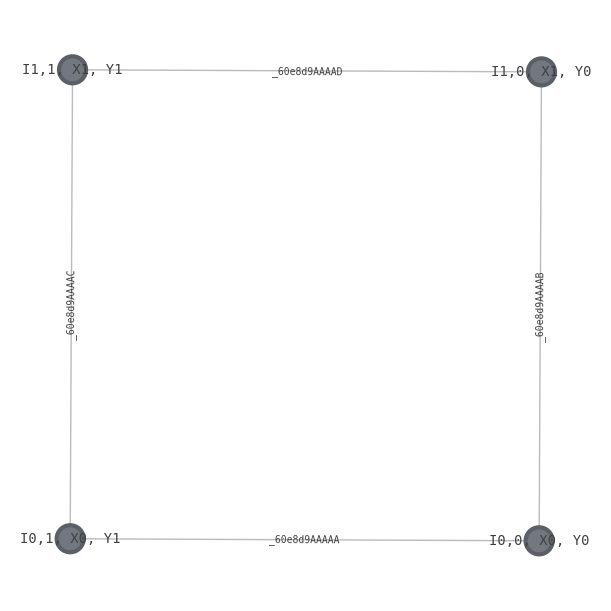

In [10]:
tensor.draw(show_inds='all')

In [11]:
def get_neighbor_tensor_message(tn, messages, tensor, ind):
    """
    Get the neighbor tensor of current tensor on bond ind and a copy of corresponding messages.
    Messages is a dict, key is a tensor, value is a dict of message vectors connected to the tensor with keys being the bond indices.

    Parameters
    ----------
    tn : TensorNetwork
        The tensor network.
    messages : dict
        The set of all message vectors connected to the on-site nodes.
        A dict of messages, key is a tensor, value is a dict of message vectors connected to the tensor with keys being the bond indices.
    tensor : Tensor
        The tensor to get neighbor tensor and corresponding messages.
    ind : str
        The index of the tensor bond to get neighbor tensor and corresponding messages.
    
    Returns
    -------
    neighbor_tensor : Tensor
        The neighbor tensor of current tensor on bond ind.
    neighbor_tensor_messages : dict
        The messages of neighbor tensor, key is the bond index of the neighbor tensor, value is the message vector.
    """
    neighbor_tensor = None
    neighbor_tensor_message = None
    oset = list(tn.ind_map[ind])
    for no in oset:
        if tn.tensor_map[no] != tensor:
            neighbor_tensor = tn.tensor_map[no]
            neighbor_tensor_message = messages[neighbor_tensor].copy()
            break
    
    return neighbor_tensor, neighbor_tensor_message

def get_neighbor_tensor_message_for_bp(tn, messages, tensor, ind):
    """
    Get the neighbor tensor of current tensor on bond ind and corresponding messages.
    The returned neighbor tensor messages do not include the message from current tensor.
    Used for belief propagation messages update.
    """
    neighbor_tensor, neighbor_tensor_message = get_neighbor_tensor_message(tn, messages, tensor, ind)
    neighbor_tensor_message.pop(ind)
    return neighbor_tensor, neighbor_tensor_message


def get_messages_from_tn(tn):
    """
    Return a dict of messages, key is a tensor, value is a dict of message tensors connected to the tensor.
    """
    from autoray import do
    messages = {}
    for tensor in tn: # Iterate over all tensors in the tensor network, general for tensor network on general graph.
        message = {}
        for ind in tensor.inds:# Do not distinguish inner indices and outer indices. TODO: distinguish inner indices and outer indices.
            message_data = do('ones', [tensor.ind_size(ind)], like=tensor.data)
            norm = do('linalg.norm', message_data, like=tensor.data)
            message_data /= norm
            message_ind = (str(ind),)
            message_tags = tn.ind_map[ind]
            message[ind] = qtn.Tensor(data=message_data, inds=message_ind, tags=message_tags)
        messages[tensor] = message # TODO: The key of messages is a tensor, which can be improved to be a tensor id to save memory.
    return messages

In [12]:
for i, j in get_messages_from_tn(tensor).items():
    print(j)

{'_60e8d9AAAAA': Tensor(shape=(2,), inds=('_60e8d9AAAAA',), tags=oset([0, 1])), '_60e8d9AAAAB': Tensor(shape=(2,), inds=('_60e8d9AAAAB',), tags=oset([0, 2]))}
{'_60e8d9AAAAA': Tensor(shape=(2,), inds=('_60e8d9AAAAA',), tags=oset([0, 1])), '_60e8d9AAAAC': Tensor(shape=(2,), inds=('_60e8d9AAAAC',), tags=oset([1, 3]))}
{'_60e8d9AAAAD': Tensor(shape=(2,), inds=('_60e8d9AAAAD',), tags=oset([2, 3])), '_60e8d9AAAAB': Tensor(shape=(2,), inds=('_60e8d9AAAAB',), tags=oset([0, 2]))}
{'_60e8d9AAAAD': Tensor(shape=(2,), inds=('_60e8d9AAAAD',), tags=oset([2, 3])), '_60e8d9AAAAC': Tensor(shape=(2,), inds=('_60e8d9AAAAC',), tags=oset([1, 3]))}


In [13]:
t1 = tensor['I1,1']

ind = t1.inds[0]
print(ind)
messages = get_messages_from_tn(tensor)
t1_neighbor, t1_neighbor_message = get_neighbor_tensor_message_for_bp(tensor, messages, t1, ind)
print(t1_neighbor)
print(t1_neighbor_message)
print(messages[t1_neighbor])
print(messages[t1][ind])

_60e8d9AAAAD
Tensor(shape=(2, 2), inds=('_60e8d9AAAAD', '_60e8d9AAAAB'), tags=oset(['I1,0', 'X1', 'Y0']), backend='numpy', dtype='float64')
{'_60e8d9AAAAB': Tensor(shape=(2,), inds=('_60e8d9AAAAB',), tags=oset([0, 2]))}
{'_60e8d9AAAAD': Tensor(shape=(2,), inds=('_60e8d9AAAAD',), tags=oset([2, 3])), '_60e8d9AAAAB': Tensor(shape=(2,), inds=('_60e8d9AAAAB',), tags=oset([0, 2]))}
Tensor(shape=(2,), inds=('_60e8d9AAAAD',), tags=oset([2, 3]), backend='numpy', dtype='float64')


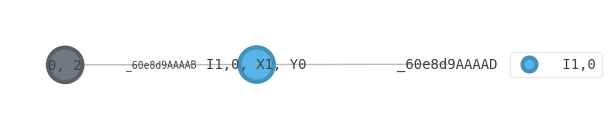

In [14]:
t_list = [t1_neighbor]
for _,message in t1_neighbor_message.items():
    t_list.append(message)
new_message = qtn.TensorNetwork(t_list, virtual=False)
new_message.draw(show_inds='all', color=list(t1_neighbor.tags)[0])

[0.70710678 0.70710678]


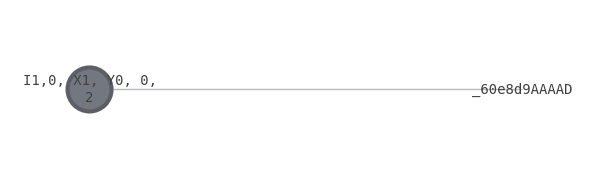

In [15]:
from autoray import do
new_message = new_message.contract()
new_message.modify(data=new_message.data/do('linalg.norm', new_message.data, like=new_message.data))
print(new_message.data)
new_message.draw()

In [16]:
print(messages[t1][ind].data)
messages[t1][ind].modify(data=new_message.data)
print(messages[t1][ind].data)

[0.70710678 0.70710678]
[0.70710678 0.70710678]


In [17]:
import quimb as qu
import quimb.tensor as qtn
from autoray import do


def loopy_belief_propagation(tn, max_iter=100, tol=1e-6, fixed_iter=False):
    """
    Perform loopy belief propagation on a tensor network.

    Parameters
    ----------
    tn : TensorNetwork object in quimb.tensor
        The tensor network on which to perform loopy belief propagation.
    max_iter : int, optional
        The maximum number of iterations to perform.
    tol : float, optional
        The tolerance for convergence.

    Returns
    -------
    dict
        Key is the on-site tensor, value is a dict of message tensors connected to the tensor with keys being the bond indices.
        Include all tensors and corresponding messages in the tensor network.
    """
    # Initialize messages
    messages = get_messages_from_tn(tn)
    
    # Iterate until convergence or maximum iterations
    # Use the old messages to calculate the new messages
    converged_ind = set()
    for _ in range(max_iter):
        for tensor in tn:
            for ind in tensor.inds:
                old_message_data = messages[tensor][ind].data
                # Obatin the new message from the belief propagation equations
                neighbor_tensor, neighbor_tensor_message = get_neighbor_tensor_message(tn, messages, tensor, ind)
                neighbor_tensor_message.pop(ind) # Remove the message from current tensor

                t_list = [neighbor_tensor]
                for _,message in neighbor_tensor_message.items():
                    t_list.append(message)
                
                new_message = qtn.TensorNetwork(t_list, virtual=False)
                new_message_contracted = new_message.contract()

                # Normalize the new message
                norm = do('linalg.norm', new_message_contracted.data, like=new_message_contracted.data)
                new_message_data = new_message_contracted.data/norm

                # Update the message
                messages[tensor][ind].modify(data=new_message_data)

                # Check for convergence
                if np.linalg.norm(np.array(new_message_data) - np.array(old_message_data)) < tol:
                    converged_ind.add(ind)
                # print(new_message_tensor.data,old_message_data)
                
        if len(converged_ind) == len(tn.ind_map) and not fixed_iter:
            print(f'Converged!')
            return messages
    if fixed_iter and len(converged_ind) == len(tn.ind_map):
        print('Converged!')
        return messages
    
    # Not converged
    print('Not converged!')
    return messages


In [18]:
ta = qtn.Tensor(data=np.random.rand(3), inds='a', tags=['a'])
tb = qtn.Tensor(data=np.random.rand(3), inds='b', tags=['b'])
tab = qtn.Tensor(data=np.random.rand(3,3), inds='ab', tags=['c'])
Tab = ta & tab & tb
print(Tab.contract())

0.6743723157274537


In [19]:
# ising_partition_function = qtn.tensor_builder.TN2D_classical_ising_partition_function(Lx=2,Ly=2,beta=1)
test_messages = loopy_belief_propagation(Tab, max_iter=100, tol=1e-6)

Converged!


In [20]:
def partition_func_numerator(final_messages):
    contraction_bp = 1
    for tensor, messages in final_messages.items():
        t_list = [tensor]
        for _,message in messages.items():
            t_list.append(message)
        t = qtn.TensorNetwork(t_list, virtual=False)
        contraction_bp *= t.contract()
    return contraction_bp
def partition_func_denominator(final_messages, tn):
    contraction_bp = 1
    for ind,oset in tn.ind_map.items():
        t1 = tn.tensor_map[list(oset)[0]]
        t2 = tn.tensor_map[list(oset)[1]]
        message1 = final_messages[t1][ind]
        message2 = final_messages[t2][ind]
        contraction_bp *= (message1 & message2).contract()
    return contraction_bp
        


In [21]:
Z = partition_func_numerator(test_messages)/partition_func_denominator(test_messages, Tab)
print(Z)

0.6743723157274538


In [23]:
def compare_bp_exact(Lx,Ly,beta,tol=1e-6,fix_iter=False,max_iter=1000):    
    partition_tn = qtn.tensor_builder.TN2D_classical_ising_partition_function(Lx=Lx,Ly=Ly,beta=beta,cyclic=True)
    messages = loopy_belief_propagation(partition_tn, max_iter=max_iter, tol=tol, fixed_iter=fix_iter)
    Z = partition_func_numerator(messages)/partition_func_denominator(messages, partition_tn)
    Z_exact = partition_tn.contract()
    relative_err=np.abs(np.log(Z_exact)-np.log(Z))/np.log(Z_exact)
    return relative_err

def exact_partition_function(Lx,Ly,beta):
    partition_tn = qtn.tensor_builder.TN2D_classical_ising_partition_function(Lx=Lx,Ly=Ly,beta=beta,cyclic=True)
    Z_exact = partition_tn.contract()
    return Z_exact

def bp_partition_function(Lx,Ly,beta,max_iter=1000,tol=1e-6,fixed_iter=False):
    partition_tn = qtn.tensor_builder.TN2D_classical_ising_partition_function(Lx=Lx,Ly=Ly,beta=beta,cyclic=True)
    messages = loopy_belief_propagation(partition_tn, max_iter=max_iter, tol=tol, fixed_iter=fixed_iter)
    Z = partition_func_numerator(messages)/partition_func_denominator(messages, partition_tn)
    return Z


In [27]:
err_list = []
beta_list = np.linspace(0.1,1,10)
for beta in beta_list:
    err_list.append(compare_bp_exact(10,10,beta,fix_iter=False,tol=1e-18))


Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!


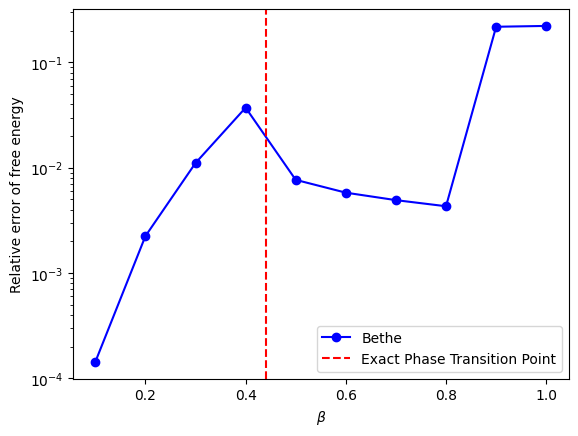

In [28]:
import matplotlib.pyplot as plt
ax = plt.subplot(111)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'Relative error of free energy')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.plot(beta_list, err_list, label='Bethe',marker='o',color='b')
# plot phase transition point 
ax.axvline(x=0.440686793509771, color='r', linestyle='--', label='Exact Phase Transition Point')
plt.legend()
plt.show()

In [31]:
import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for color in colors:
    print(color)


#1f77b4
#ff7f0e
#2ca02c
#d62728
#9467bd
#8c564b
#e377c2
#7f7f7f
#bcbd22
#17becf


In [29]:
exact_Z_list = []
bp_Z_list = []
for beta in beta_list:
    exact_Z_list.append(exact_partition_function(4,4,beta))
    bp_Z_list.append(bp_partition_function(4,4,beta, tol=1e-10, fixed_iter=True))


Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!


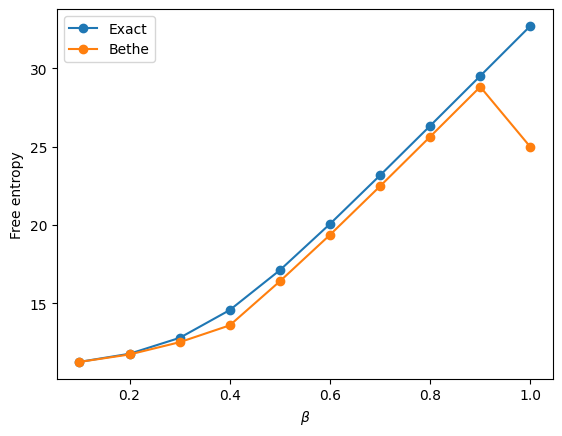

In [32]:
exact_F_list = np.log(exact_Z_list)
bp_F_list = np.log(bp_Z_list)
ax2 = plt.subplot(111)
ax2.set_xlabel(r'$\beta$')
ax2.set_ylabel(r'Free entropy')
ax2.plot(beta_list, exact_F_list, label='Exact',marker='o',color=colors[0])
ax2.plot(beta_list, bp_F_list, label='Bethe',marker='o',color=colors[1])
plt.legend()

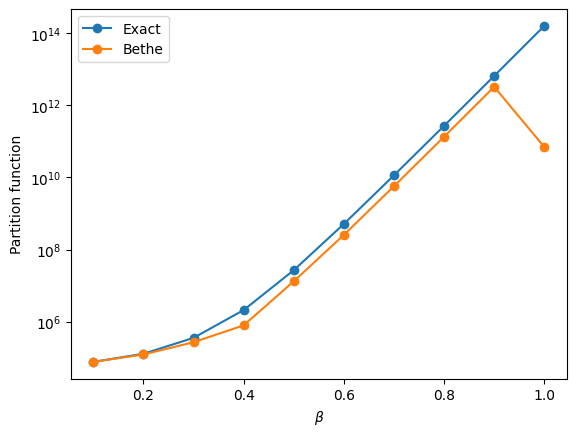

In [33]:
ax1 = plt.subplot(111)
ax1.set_xlabel(r'$\beta$')
ax1.set_ylabel('Partition function')
ax1.set_yscale('log')
ax1.plot(beta_list, exact_Z_list, label='Exact',marker='o')
ax1.plot(beta_list, bp_Z_list, label='Bethe',marker='o')
plt.legend()
plt.show()

In [684]:
partition_3d_ising = qtn.tensor_builder.TN3D_classical_ising_partition_function(Lx=3,Ly=3,Lz=3,beta=0.5)
value = np.log(partition_3d_ising.contract())
print(value)

28.59763574003703


In [30]:
def compare_bp_exact_3d(Lx,Ly,Lz,beta,tol=1e-6,fix_iter=False,max_iter=1000):    
    partition_tn = qtn.tensor_builder.TN3D_classical_ising_partition_function(Lx=Lx,Ly=Ly,Lz=Lz,beta=beta)
    messages = loopy_belief_propagation(partition_tn, max_iter=max_iter, tol=tol, fixed_iter=fix_iter)
    Z = partition_func_numerator(messages)/partition_func_denominator(messages, partition_tn)
    Z_exact = partition_tn.contract()
    relative_err=np.abs(np.log(Z_exact)-np.log(Z))/np.log(Z_exact)
    return relative_err

def exact_partition_function_3d(Lx,Ly,Lz,beta):
    partition_tn = qtn.tensor_builder.TN3D_classical_ising_partition_function(Lx=Lx,Ly=Ly,Lz=Lz,beta=beta)
    Z_exact = partition_tn.contract()
    return Z_exact

def bp_partition_function_3d(Lx,Ly,Lz,beta,max_iter=1000,tol=1e-6,fixed_iter=False):
    partition_tn = qtn.tensor_builder.TN3D_classical_ising_partition_function(Lx=Lx,Ly=Ly,Lz=Lz,beta=beta)
    messages = loopy_belief_propagation(partition_tn, max_iter=max_iter, tol=tol, fixed_iter=fixed_iter)
    Z = partition_func_numerator(messages)/partition_func_denominator(messages, partition_tn)
    return Z

In [33]:
err_list = []
beta_list = np.linspace(0.1,1,10)
for beta in beta_list:
    err_list.append(compare_bp_exact_3d(5,5,5,beta,fix_iter=False,tol=1e-20))

Converged!


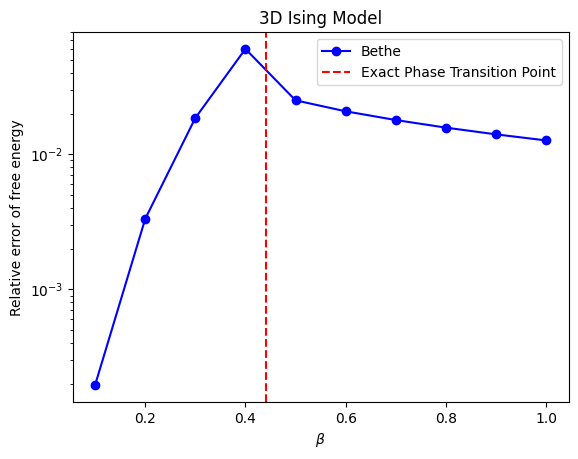

In [32]:
import matplotlib.pyplot as plt
ax = plt.subplot(111)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'Relative error of free energy')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.plot(beta_list, err_list, label='Bethe',marker='o',color='b')
# plot phase transition point 
ax.axvline(x=0.440686793509771, color='r', linestyle='--', label='Exact Phase Transition Point')
plt.legend()
plt.title('3D Ising Model')
plt.show()

In [5]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp
import sys


def contract_HTN_partition(tn):
    """
    Exactly contract the hyper tensor network to get the partition function.
    """
    import quimb.tensor as qtn
    tensor_list = []
    for tensor in tn.tensor_map.values():
        tensor_list.append(tensor)
    value = qtn.tensor_contract(*tensor_list, output_inds=[])
    return value

L = 1  # Lattice size
N_a = 2 # Number of lattice points along each direction
N = N_a**3  # Total number of lattice
T = 10 # Temperature
beta = 1/T

tn = qtn.tensor_builder.HTN3D_classical_LennardJones_partition_function_spinrep(
    Lx=L,Ly=L,Lz=L,
    beta=beta,
    Nx=N_a,Ny=N_a,Nz=N_a,
    cutoff=2.0,
    epsilon=1.0,
    sigma=1.0
    )

In [6]:
tn

TensorNetwork(tensors=24, indices=8)